# Simulating Credit Risk in a USD/CLP Forward Contract with Market-Based Collateral (Bonds + Equities)


This notebook demonstrates how banks evaluate the credit risk of a foreign exchange (FX) derivative—specifically a USD/CLP forward contract—when the counterparty provides financial assets as collateral. Using Monte Carlo simulation, we estimate the Potential Future Exposure (PFE) of the transaction, both with and without collateral.

We simulate thousands of future scenarios for the USD/CLP exchange rate, as well as the market value of the collateral: U.S. Treasury bonds (low volatility) and Apple stock (high volatility). The goal is to measure how effective these assets are in protecting the bank from future credit losses in case the client defaults.

The notebook walks through each step in detail:
- How the forward contract creates potential exposure for the bank.
- How market volatility impacts both the derivative and the collateral.
- How net exposure is calculated across thousands of future scenarios.
- How collateral transforms a high-risk exposure into a fully protected transaction.

This analysis replicates a realistic workflow used in corporate lending and derivative risk management, and is structured to be accessible even to readers without a quantitative finance background.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Define Contract Terms and Simulation Settings

Before simulating anything, we need to set up the context of the transaction.

Imagine this: A high-net-worth client in Chile wants to **lock in a future USD/CLP exchange rate** because they expect the dollar might go up. The bank enters into a **forward contract** with the client: in 6 months, the client will buy USD at a fixed rate of **900 CLP/USD**.

Now, from the bank’s point of view, this is a **credit risk**: if the exchange rate rises significantly, the client would gain (they get to buy cheap dollars), but the **bank would lose**. If the client defaults and can’t pay, the bank is exposed. That's what we want to estimate.

So, we define the key variables involved in the simulation:

- `notional_usd = 5_000_000` → This is the size of the forward contract. The client will buy **USD 5 million** in 6 months.
- `spot_fx = 890` → This is the current market exchange rate: **890 CLP per USD**.
- `forward_fx = 900` → This is the rate locked in by the forward contract: the client will get **900 CLP/USD**.
- `vol_fx = 0.10` → Estimated **volatility** of the USD/CLP exchange rate: 10% per year.
- `rf_usd = 0.03` and `rf_clp = 0.06` → The **risk-free interest rates** in USD and CLP. These influence the expected drift in FX simulation.
- `T = 0.5` → The time horizon: **0.5 years = 6 months**, which is when the contract matures.
- `n_paths = 10000` → We'll simulate **10,000 possible future exchange rate scenarios** using Monte Carlo simulation. Each one represents a different potential future.
- `n_steps = 60` → We'll break the 6 months into 60 smaller steps (like days or weeks) to simulate the FX path more smoothly.
- `dt = T / n_steps` → This gives the length of each small step (in years).
- `np.random.seed(42)` → This is just to make sure we get the same results every time we run the simulation. It makes the randomness **reproducible**.

Why do we need all this? Because we're going to simulate the exchange rate path using a model called **Geometric Brownian Motion (GBM)**. This model uses the volatility, interest rate differential, and time horizon to generate **realistic future price paths**. Once we have the FX rate in 6 months, we can calculate how much the bank could lose.

In short: this cell sets the foundation for everything. It tells the simulation engine: “Here's the contract, here's the market, now give me thousands of possible future outcomes.”


In [2]:
notional_usd = 5_000_000
spot_fx = 890
forward_fx = 900
vol_fx = 0.10
rf_usd = 0.03
rf_clp = 0.06
T = 0.5
n_paths = 10000
n_steps = 60
dt = T / n_steps
np.random.seed(42)

## Simulate Future FX Rate Paths (USD/CLP)

Now that we have defined the contract and market parameters, the next step is to **simulate how the USD/CLP exchange rate could evolve** over the next 6 months.

In simple words:  
 We create **10,000 possible futures** for the FX rate, one for each scenario.

### How do we simulate it?

We use a method called **Geometric Brownian Motion (GBM)**, which is widely used in finance because:
- It models prices that can **grow exponentially** over time.
- It **includes randomness** to simulate the uncertainty of real markets.
- It prevents negative prices (very important for FX rates).

### What happens in this code?

- `fx_paths = np.zeros((n_paths, n_steps + 1))`  
  → We create a big matrix where each row is a simulation (10,000 rows) and each column is a time step (60 steps).
  
- `fx_paths[:, 0] = spot_fx`  
  → We set the starting point for all simulations to the **current FX rate**: 890 CLP/USD.

- `mu_fx = rf_clp - rf_usd`  
  → We calculate the expected drift based on **interest rate differential** between CLP and USD.  
  (This follows the concept of **Covered Interest Rate Parity**.)

- Then we simulate each next step with a loop:
  - At every time step `t`:
    - `z = np.random.normal(0, 1, n_paths)`  
      → We draw 10,000 random numbers from a standard normal distribution to introduce randomness.
    - `fx_paths[:, t] = fx_paths[:, t - 1] * exp((mu_fx - 0.5 * vol_fx**2) * dt + vol_fx * sqrt(dt) * z)`  
      → This formula updates the FX rate based on:
        - Drift (`mu_fx`)
        - Volatility (`vol_fx`)
        - Random market shocks (`z`)
        - Small time step (`dt`)

This way, each simulated path is slightly different, and after 6 months, we will have **a full distribution of possible FX rates**.

### Why is this important?

- The future FX rate will determine **how much the bank could lose or win** under the forward contract.
- We will later use these final FX values to **calculate the exposure** in each scenario.
- This creates the **risk distribution** we need to calculate the Potential Future Exposure (PFE).

In short: this cell generates 10,000 different USD/CLP futures so we can see **what could happen to the bank's risk** under many different market conditions.


In [3]:
fx_paths = np.zeros((n_paths, n_steps + 1))
fx_paths[:, 0] = spot_fx
mu_fx = rf_clp - rf_usd
for t in range(1, n_steps + 1):
    z = np.random.normal(0, 1, n_paths)
    fx_paths[:, t] = fx_paths[:, t - 1] * np.exp((mu_fx - 0.5 * vol_fx**2) * dt + vol_fx * np.sqrt(dt) * z)

In [4]:
# Collateral: Bonds and Apple stock
precio_bonos_inicial = 100
unidades_bonos = 50_000
vol_bonos = 0.03
bonos = np.zeros((n_paths, n_steps + 1))
bonos[:, 0] = precio_bonos_inicial
precio_accion_inicial = 200
unidades_accion = 25_000
vol_accion = 0.25
acciones = np.zeros((n_paths, n_steps + 1))
acciones[:, 0] = precio_accion_inicial
for t in range(1, n_steps + 1):
    z_bonos = np.random.normal(0, 1, n_paths)
    z_accion = np.random.normal(0, 1, n_paths)
    bonos[:, t] = bonos[:, t - 1] * np.exp(-0.5 * vol_bonos**2 * dt + vol_bonos * np.sqrt(dt) * z_bonos)
    acciones[:, t] = acciones[:, t - 1] * np.exp(-0.5 * vol_accion**2 * dt + vol_accion * np.sqrt(dt) * z_accion)

## Simulate the Future Value of Collateral (Treasury Bonds and Apple Stock)

Now that we have simulated the possible future values of the FX rate, we must do the same for the **collateral** provided by the client.

In real life, the value of collateral is not static.  
- Bonds fluctuate based on interest rates.
- Stocks fluctuate based on company performance and overall market conditions.

If the collateral value drops significantly while the exposure increases, the bank could be left unprotected.  
Therefore, we simulate how both types of collateral might behave under market uncertainty.

### What happens in this code?

First, we simulate **Treasury Bonds**:

- `precio_bonos_inicial = 100`  
  → Initial price of each bond in USD.
- `unidades_bonos = 50,000`  
  → The client holds 50,000 units, making the bond portfolio worth USD 5 million initially.
- `vol_bonos = 0.03`  
  → Annualized volatility of the bonds. This is low because US Treasury bonds are relatively stable.
- `bonos = np.zeros((n_paths, n_steps + 1))`  
  → Creates a matrix to store the price paths of the bonds across all scenarios.
- `bonos[:, 0] = precio_bonos_inicial`  
  → Set the starting bond price for all scenarios.

Then, we simulate **Apple Stock**:

- `precio_accion_inicial = 200`  
  → Initial price per Apple share in USD.
- `unidades_accion = 25,000`  
  → The client owns 25,000 shares, also worth USD 5 million initially.
- `vol_accion = 0.25`  
  → Annualized volatility of the Apple stock. This is much higher because stocks are riskier than bonds.
- `acciones = np.zeros((n_paths, n_steps + 1))`  
  → Matrix to store the stock price paths.
- `acciones[:, 0] = precio_accion_inicial`  
  → Set the starting stock price for all simulations.

Now, we simulate how both assets evolve over time:

- For each time step `t`, we generate random shocks:
  - `z_bonos = np.random.normal(0, 1, n_paths)`  
    → Random shocks for bonds.
  - `z_accion = np.random.normal(0, 1, n_paths)`  
    → Random shocks for Apple stock.
- We update the price of each asset according to the standard **Geometric Brownian Motion formula**, which includes:
  - Drift term (-0.5 × volatility² × dt) to correct for bias.
  - Volatility term (volatility × sqrt(dt) × random shock) to introduce uncertainty.

Each asset is simulated independently to reflect their unique market behaviors.

### Why is this important?

Because just like the FX rate is uncertain, the **value of the collateral is also uncertain**.  
Some future scenarios might have:
- Higher collateral values (good protection for the bank).
- Lower collateral values (risk of under-collateralization).

By simulating both the FX exposure and the collateral together, we can **realistically measure the net risk** to the bank over time.

In short: this cell simulates how much the client's Treasury bonds and Apple stock could be worth at the maturity date, across 10,000 different future scenarios.


In [5]:
fx_final = fx_paths[:, -1]
valor_forward = (fx_final - forward_fx) * notional_usd
exposiciones_positivas = np.maximum(valor_forward, 0)
valor_bonos = bonos[:, -1] * unidades_bonos * fx_final
valor_acciones = acciones[:, -1] * unidades_accion * fx_final
colateral_total = valor_bonos + valor_acciones
exposicion_neta = np.maximum(valor_forward - colateral_total, 0)
pfe_sin_colateral = np.percentile(exposiciones_positivas, 95)
pfe_con_colateral = np.percentile(exposicion_neta, 95)

In [9]:
print(f' PFE without collateral:     {pfe_sin_colateral:,.0f} CLP')
print(f' PFE with full collateral:   {pfe_con_colateral:,.0f} CLP')

 PFE without collateral:     558,498,277 CLP
 PFE with full collateral:   0 CLP


## What Do These PFE Results Tell Us?

The two results we just calculated represent two very different risk profiles for the bank:

- **PFE without collateral: 558,498,277 CLP**  
  This means that, based on our simulation, in the worst 5% of the scenarios, the bank could lose up to **558 million Chilean pesos** if the client defaults and no collateral is available.  
  In other words, the exposure is high and the bank would be taking a significant risk if it approved the forward contract without any guarantee.

- **PFE with full collateral: 0 CLP**  
  After factoring in the future simulated value of the collateral (Treasury bonds + Apple stock), the worst-case net exposure drops to **zero**.  
  This means that in all scenarios, even in the most adverse ones, the collateral value is sufficient to fully cover the potential loss of the bank.

### Why is this important?

- Without collateral, the bank faces real credit risk.
- With the given collateral, the risk is neutralized.
- The client’s portfolio of assets, even under simulated adverse conditions, remains strong enough to fully protect the bank’s position.

This result strongly supports approving the transaction from a credit risk perspective.

### Key Takeaways:

- The PFE gives us a quantitative way to measure credit exposure under uncertainty.
- Good quality and diversified collateral significantly reduce (or eliminate) potential losses.
- Monte Carlo simulations allow us to test how resilient the collateral would be across thousands of different market scenarios.



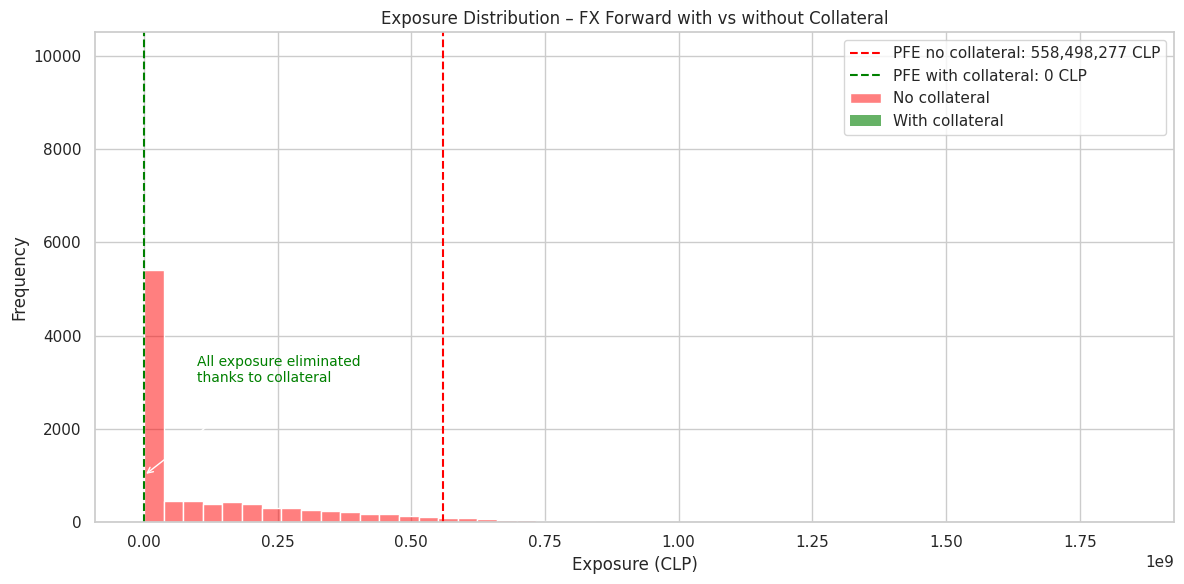

In [10]:
plt.figure(figsize=(12,6))

sns.histplot(exposiciones_positivas, bins=50, label='No collateral', color='red', alpha=0.5)
sns.histplot(exposicion_neta, bins=50, label='With collateral', color='green', alpha=0.6)

plt.axvline(pfe_sin_colateral, color='red', linestyle='--', label=f'PFE no collateral: {pfe_sin_colateral:,.0f} CLP')
plt.axvline(pfe_con_colateral, color='green', linestyle='--', label=f'PFE with collateral: {pfe_con_colateral:,.0f} CLP')

plt.annotate("All exposure eliminated\nthanks to collateral",
             xy=(pfe_con_colateral, 1000),
             xytext=(pfe_con_colateral + 1e8, 3000),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='green')

plt.title('Exposure Distribution – FX Forward with vs without Collateral')
plt.xlabel('Exposure (CLP)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Visual Comparison of Exposure Distributions

This chart compares the **distribution of future exposures** the bank could face under two scenarios:

- **Without collateral** (red): This shows the full potential losses the bank might suffer from the FX forward if the client defaults and offers no collateral. The exposure can reach over **500 million CLP** in the worst 5% of cases (PFE).

- **With collateral** (green): This shows the same 10,000 simulated scenarios, but now subtracting the future value of the client’s collateral (Treasury bonds and Apple stock). As shown, all exposures are completely offset, and the net exposure is reduced to **zero** in every single case.

### Key Observations:
- The **red distribution** has a long tail, meaning that there are many adverse scenarios where the bank could lose large sums.
- The **green distribution is compressed at zero**, meaning that the collateral covers all possible losses—even in the worst-case simulations.
- The **dashed lines** represent the 95th percentile (PFE) in each case:
  - Without collateral: ~558 million CLP
  - With collateral: 0 CLP

### Why this matters:
This chart clearly shows the **impact of good-quality collateral** on risk. The same forward contract becomes significantly safer for the bank when it’s backed by liquid and stable assets. This type of visual evidence is commonly used by credit officers and risk managers to support lending decisions.

In summary, the collateral transforms a high-risk transaction into a fully protected one.


In [11]:
min_valor_colateral = np.min(colateral_total)
worst_idx = np.argmin(colateral_total)
print(f' Worst collateral value: {min_valor_colateral:,.0f} CLP')
print(f' Exposure in that scenario: {valor_forward[worst_idx]:,.0f} CLP')
print(f' Net exposure: {exposicion_neta[worst_idx]:,.0f} CLP')

 Worst collateral value: 6,049,949,623 CLP
 Exposure in that scenario: -725,792,127 CLP
 Net exposure: 0 CLP


## Worst-Case Collateral Scenario

In our 10,000 simulations, this was the **worst case** in terms of collateral value.

- The total value of the client's collateral (bonds + Apple stock) dropped to about **6.05 billion CLP**.
- In that same scenario, the FX forward **was favorable to the bank** (negative exposure), meaning the client would actually owe less.
- As a result, the **net exposure for the bank remained at 0 CLP**.

### What does this mean?

Even in the most extreme simulation—where the client's assets dropped significantly—the bank was still protected.  
Why? Because the FX market didn't move against the bank in that case. The contract ended up **not generating a loss**, so **no collateral was needed**.

This confirms that the transaction is safe not just in typical scenarios, but also in very adverse market conditions.
